<h1> Model </h1>

In [76]:
from torch.utils.data import Dataset
import torch
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import torch.nn as nn
import torch.nn.functional as F

In [108]:
class model(nn.Module):
    '''
    
    '''
    def __init__(self, image_channels=3, img_size=(64,64),device='cpu'):  
        self.device=device
        self.img_size=img_size
        self.image_channels= image_channels
        super(model, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x

In [78]:
class mylog:
    def __init__(self,file='auto',path='./',mode='new'):
        assert mode in ['new','append','load']
        if file =='auto' and mode != 'new':
            raise Exception("parametres file et mode incompatibles") 
        if file =='auto' and (mode == 'load' or mode =='append'):
            raise Exception("parametres file et mode incompatibles") 
            
        if file == 'auto':
            count=0
            while 1:
                name='training.{:04d}.log'.format(count)
                self.namesavefig= 'training.{:04d}.png'.format(count)
                f=path+name
                if not os.path.isfile(f):
                    break
                else:
                    count +=1
            self.name=f
        else:
            self.name=path+file
            
            
        if mode =='new' and os.path.isfile(self.name):
            os.remove(self.name)
        self.path=path
        self.mode=mode
        #print('name=',self.name)
            
    def __call__(self,phase,epoch,plot=False,**loss):
        if self.mode == 'load':
            return False
        with open (self.name, 'a') as f:
            f.write('{} {} '.format(phase,epoch))
            for label,val in loss.items():
                try :
                    f.write('{} {:.4f} '.format(label,float(val)))
                except:
                    f.write('{} {} '.format(label,val))    
            f.write('\n')
        if plot:
            self.plot(title='loss')
            
        return True
    
    def summarize(self):
        import numpy as np
        
        mat = []                            # création d'une liste vide,
        with open (self.path+self.name, "r") as f:  # ouverture du fichier en mode lecture
            for li in f :                   # pour toutes les lignes du fichier
                s = li.strip ("\n\r")       # on enlève les caractères de fin de ligne
                l = s.split (" ")           # on découpe en colonnes
                l=[x for x in l[:-1]]
                mat.append (l)  
        
        
        for l in mat:
            if l[0] in ['hyperparams']:
                dico={}
                for i in range(2,len(l),2):
                    try:
                        dico[l[i]] = float(l[i+1])
                    except:
                        dico[l[i]] = l[i+1]
                return dico
        return dico
    
    def read(self,title=None,save=False,hold=False):
        
        import numpy as np
        
        mat = []                            # création d'une liste vide,
        with open (self.path+self.name, "r") as f:  # ouverture du fichier en mode lecture
            for li in f :                   # pour toutes les lignes du fichier
                s = li.strip ("\n\r")       # on enlève les caractères de fin de ligne
                l = s.split (" ")           # on découpe en colonnes
                l=[x for x in l[:-1]]
                mat.append (l)  
        
        dico={}
        for l in mat:
            if l[0] not in ['train','val','test']:
                continue
            try:
                dico[l[0]] = []
            except:
                pass
        
        for l in mat:
            if l[0] not in ['train','val','test']:
                continue
            loss={}
            for i,c in enumerate(l[2::2]):
                loss[c]=float(l[2*i+3])
                            
            d=(int(l[1]),loss)
            dico[l[0]].append(d)
            
                  
        return dico
            #mat=np.array(mat)
    def plot(self,title='loss',save=None,hold=False,ylim=False,mask=None):
        
        loss=self.read()
       
        plt.figure(title)
        if not hold : plt.clf()
        
        if title is not None:
            plt.suptitle(title)
        for phase in loss.keys():
            if mask is None:
                nserie=len(loss[phase][0][1])
                series = list(loss[phase][0][1].keys())
            else:
                nserie=len(mask)
                series=mask
            
            for serie in series:
                X,Y=[],[]
                for l in loss[phase]:
                    X.append(l[0])
                    Y.append(l[1][serie])
                if len(X) ==1:
                    plt.plot(X,Y,'X',label=phase+':'+serie)
                else:
                    plt.plot(X,Y,label=phase+':'+serie)
                    
            
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid()
        if ylim is not None:
            plt.ylim(ylim)
        if save is not None:
            plt.savefig(self.path+save)
        #print(mat)
        plt.pause(0.1)

In [79]:
class DatasetCifar64(Dataset):
    """
    Création d'un dataset permettant de lire les données Cifar64 partir d'un fichier npz
    créé par create_dataset.py"""

    def __init__(self, file, path='./',split=None):
        """
        Args:
        
        """
        if not os.path.exists(file):
                raise FileNotFoundError('fichier {} introuvable'.format(file))
        tmp=np.load(path+file)
        self.imgs=tmp['imgs'].transpose([0,3,1,2])
        
        self.labels=tmp['labels']
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx=idx.tolist()
        img=self.imgs[idx]
        img=torch.from_numpy(img).to(torch.float)/255.0
        labels=torch.from_numpy(self.labels[idx]).to(torch.float)
        
        return img,labels 

tensor([1., 0., 1., 0., 0., 1., 0., 0., 0., 1.])
Exemple d"image de la base de train


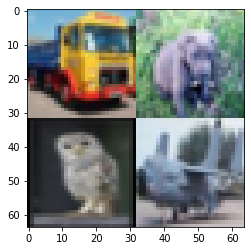

In [80]:
from torch.utils.data import DataLoader
   
traindataset=DatasetCifar64('train20k.npz')
   
train_dataloader = DataLoader(traindataset, batch_size=5, shuffle=True)
print(traindataset[0][1])
plt.imshow(traindataset[0][0].permute(1,2,0))
print('Exemple d"image de la base de train')

<h1> Learning </h1>

In [96]:
def Train(model, dataloaders, loss_fn, optimizer, num_epochs=0, plot=True,verbose=True):
    """ Module d'apprentissage: si epoch == 0 alors on calcule seulement de loss sur le dataset de test
        
    """
    since = time.time()

    
    best_loss = np.inf
    epoch_loss = np.inf

       
    phases = ['train','val']
    if num_epochs ==0:
        phases = ['test']
       

    if 'train' in phases :
        print('Apprentissage avec {} epoques'.format(num_epochs))
        best_model = copy.deepcopy(model)
    else:
        best_model=model
    
    
    
    for epoch in range(num_epochs):
        
        if 'train' in phases:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in phases:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            
            
            # Iterate sur tous les batch.
            for idx, (images,labels) in enumerate(dataloaders[phase]):
                
                imagesIn= images.to(model.device)
                Out = labels.to(model.device)
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    labelsOut = model.forward(imagesIn)
                    
                    loss = loss_fn(labelsOut, Out)      
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                
                # statistics
                running_loss += loss.item() / 10
                
            epoch_loss = running_loss / len(dataloaders[phase]) 
            
            model.log(phase,epoch,Loss=epoch_loss,plot=False)
            
            if plot:
                model.log.plot(mask=['Loss'])
            print('{} Loss: {:.4f} '.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch == 0:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)
            elif phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)
            
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    if num_epochs > 0:
        print('Best loss: {:4f} final loss: {:4f}'.format(best_loss,epoch_loss))
        print('-------------------------------------------------')

   
    
    if num_epochs ==0:
        return model,model,epoch_loss,epoch_loss
    else:
        return model, best_model, epoch_loss, best_loss

In [97]:
batch_size = 256        # Taille du batch
learning_rate=5e-4      # Learning rate
epochs=20            # Nombre d'époques
load_net=True           # Chargement du modele depuis le fichier weight_file_load
save_net=True           # Sauvegarde modele dans fichier
weight_file_load='basique.torch'      # fichier de chargement du modele
weight_file_save='basique.torch'      # fichier sauvegarde du modele
    
logfile='logfile.log'     # nom du fichier log
    
# GPU ou CPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Les calculs se font sur ', device)

Les calculs se font sur  cpu


In [98]:
traindataset=DatasetCifar64('train20k.npz')
valdataset=DatasetCifar64('val5k.npz')
testdataset=DatasetCifar64('test20k.npz')

In [99]:
train_dataloader = DataLoader(traindataset, batch_size=batch_size, shuffle=True,num_workers=1)
test_dataloader = DataLoader(testdataset, batch_size=batch_size, shuffle=False,num_workers=1)
val_dataloader = DataLoader(valdataset, batch_size=batch_size, shuffle=False,num_workers=1)

In [100]:
loaders = {'train':train_dataloader,'val':val_dataloader,'test':test_dataloader}

In [109]:
nn_model = model(img_size=(64,64),device=device).to(device)
nn_model.log= mylog(file=logfile,mode='new',path='./')
    
loss_fn=nn.MSELoss().to(device)   
optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate) 

In [110]:
load_net = False
if load_net :
        print('Chargement des poids depuis ',weight_file_load)
        checkpoint = torch.load(weight_file_load,map_location=device)
        nn_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
        print("Pas de chargement des poids")

Pas de chargement des poids


In [111]:
my_model, best_model, epoch_loss, best_loss = Train(nn_model, loaders, loss_fn, optimizer, num_epochs=epochs,plot=True,verbose=True)

Apprentissage avec 20 epoques
Epoch 0/19
----------


/home/joker/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([256, 10])) that is different to the input size (torch.Size([1024, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (1024) must match the size of tensor b (256) at non-singleton dimension 0

In [54]:
if save_net: 
        torch.save({'model_state_dict':best_model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),'loss':best_loss,'learning_rate':learning_rate},weight_file_save )
        print('Sauvé dans ',save_net)

Sauvé dans  True


In [60]:
print(testdataset[0][1])

tensor([0., 0., 1., 1., 0., 1., 0., 0., 1., 0.])


In [65]:
res = nn_model(testdataset[0][0])

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [6, 3, 5, 5], but got 3-dimensional input of size [3, 64, 64] instead